#Libraries and data

In [1]:
%cd /content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/6. Tensorflow Probabilities Structural Time Series

/content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/6. Tensorflow Probabilities Structural Time Series


In [2]:
#import libraries
import pandas as pd
import numpy as np
import tensorflow_probability as tfp

In [3]:
#load the data
df = pd.read_csv("Udemy_wikipedia_visits.csv",
                 index_col = "Date",
                 parse_dates = True)
df.head()

,Udemy,Easter,Christmas
Date,,,
2016-01-01,311,0,0
2016-01-02,564,0,0
2016-01-03,517,0,0
2016-01-04,652,0,0
2016-01-05,756,0,0


#Regressors

In [4]:
#isolate regressors
exog = np.asmatrix(df.iloc[:, 1:].astype(np.float64))

In [5]:
regressors = tfp.sts.LinearRegression(design_matrix=exog,
                                      name = "regressors")

#Training and test set

In [6]:
test_days = 31
training_set = df.iloc[:-test_days,:]
test_set = df.iloc[-test_days:,:]

In [7]:
#isolate y
y = training_set.Udemy.astype(np.float64)

#Seasonality

In [13]:
weekday_effect = tfp.sts.Seasonal(num_seasons = 7,
                                   num_steps_per_season = 1,
                                   observed_time_series = y,
                                   name = 'weekday_effect')

In [11]:
df.tail(1)

,Udemy,Easter,Christmas
Date,,,
2020-12-31,1635,0,0


In [12]:
num_days_per_month = np.array(
    [[31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], #2016 Leap Yeah
     [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
     [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
     [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
     ]
)

In [14]:
#Monthly seasonality
monthly_effect = tfp.sts.Seasonal(num_seasons = 12,
                                   num_steps_per_season = num_days_per_month,
                                   observed_time_series = y,
                                   name = 'monthly_effect')

#Trend and seasonality

In [15]:
#trend
trend = tfp.sts.LocalLinearTrend(observed_time_series = y,
                                 name = "trend")

In [17]:
#autoregressive
autoregressive = tfp.sts.Autoregressive(order = 1,
                                        observed_time_series = y,
                                        name = 'autoregressive')

#Model

In [18]:
model = tfp.sts.Sum([regressors,
                     weekday_effect,
                     monthly_effect,
                     autoregressive,
                     trend],
                    observed_time_series = y )

In [19]:
#Fitting
samples, kernel_results = tfp.sts.fit_with_hmc(model,
                                               y,
                                               num_results = 10,
                                               num_warmup_steps = 10,
                                               num_leapfrog_steps = 5,
                                               num_variational_steps = 15,
                                               seed = 1502)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:341: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


#Forecasting and Viz

In [21]:
forecast = tfp.sts.forecast(model,
                            y,
                            parameter_samples = samples,
                            num_steps_forecast = 31)

In [22]:
#predictions
predictions_tfp = pd.Series(forecast.mean()[:,0], name = "TFP")
predictions_tfp.index = test_set.index

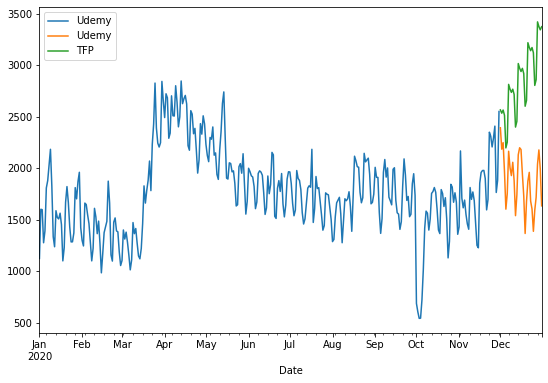

In [24]:
#Viz
training_set.Udemy['2020-01-01':].plot(figsize = (9, 6),
                        legend = True)
test_set.Udemy.plot(legend = True)
predictions_tfp.plot(legend = True)